In [2]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
##Importing modules
import pandas as pd
import os
import json



In [5]:
##Reading data 
fn = "/content/drive/MyDrive/Polynomial.ai/Cell_Phones_and_Accessories.json.gz"
print(os.path.isfile(fn))
df=pd.read_json(fn, lines=True, compression="gzip", nrows=500000)

df.head()

True


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
0,5,False,"11 19, 2014",A1GG51FWU0XQYH,098949232X,Paul Williams,If your into space this is the Calendar for you.,Five Stars,1416355200,NaN,NaN,NaN
1,5,False,"11 19, 2014",AVFIDS9RK38E0,098949232X,Sean Powell,Awesome pictures!,Five Stars,1416355200,NaN,NaN,NaN
2,5,False,"11 19, 2014",A2S4AVR5SJ7KMI,098949232X,Tom Davis,Great wall art and information for space explo...,Five Stars,1416355200,NaN,NaN,NaN
3,5,False,"11 19, 2014",AEMMMVOR9BFLI,098949232X,Kwajmeck,"As always, it is a quality calendar full of ve...",I love it. I buy a new one every year,1416355200,NaN,NaN,NaN
4,5,False,"11 19, 2014",A2DZXMBTY7KLYP,098949232X,ScottG43,This is a fantastic calendar. This is my third...,Great Calendar.,1416355200,NaN,NaN,NaN


In [6]:
df.isna().any()

overall           False
verified          False
reviewTime        False
reviewerID        False
asin              False
reviewerName       True
reviewText         True
summary            True
unixReviewTime    False
vote               True
image              True
style              True
dtype: bool

In [7]:
len(df)

500000

In [8]:
df.describe()

,overall,unixReviewTime
count,500000.000000,5.000000e+05
mean,3.753160,1.350605e+09
std,1.503032,7.365208e+07
min,1.000000,9.413280e+08
25%,3.000000,1.310861e+09
50%,4.000000,1.357171e+09
75%,5.000000,1.401149e+09
max,5.000000,1.528848e+09


In [9]:
df.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'image', 'style'],
      dtype='object')

In [10]:
df.shape

(500000, 12)

In [11]:
df.isna().sum()

overall                0
verified               0
reviewTime             0
reviewerID             0
asin                   0
reviewerName          28
reviewText            99
summary               65
unixReviewTime         0
vote              432982
image             497966
style             355156
dtype: int64

In [12]:
rating = df["overall"]
rating.unique()

array([5, 3, 2, 4, 1])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


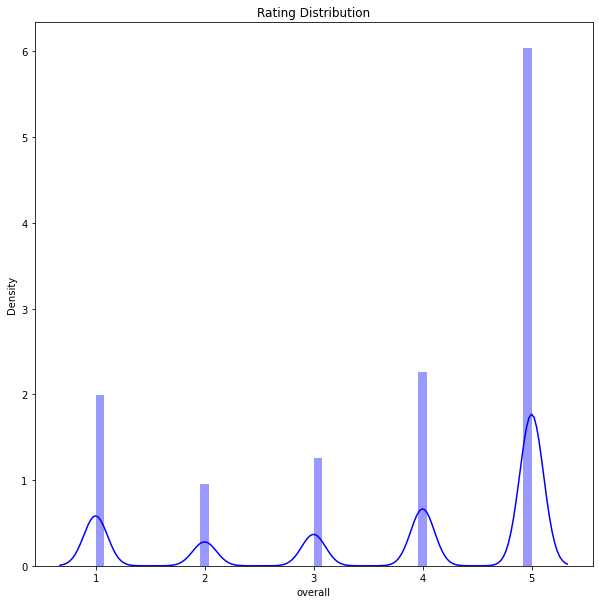

In [13]:
##Ratinf Distribution
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))
plt.title("Rating Distribution")

sns.distplot(rating,color="blue")

In [14]:
type(rating)

pandas.core.series.Series

In [15]:
df.drop(['verified', 'reviewTime','reviewerID','asin','reviewerName','unixReviewTime','vote','image', 'style'], axis=1)

,overall,reviewText,summary
0,5,If your into space this is the Calendar for you.,Five Stars
1,5,Awesome pictures!,Five Stars
2,5,Great wall art and information for space explo...,Five Stars
3,5,"As always, it is a quality calendar full of ve...",I love it. I buy a new one every year
4,5,This is a fantastic calendar. This is my third...,Great Calendar.
...,...,...,...
499995,2,I got this in the mail the other day. Its sup...,Cute but cheap
499996,5,It's adorable. Not he best quality but for $4...,Black Rilakkuma Cat Cover for iPhone 4
499997,5,I got it for my besties! :D Even though the ba...,Love it!
499998,5,"I love this iPhone case soooo much, super cute...",Love love love


In [16]:
##Creating new dataframe for model training
df_1 = pd.DataFrame(df,columns = ['overall','reviewText'])
df_1.rename(columns = {'overall':'Rating','reviewText':'Review'},inplace = True)

In [17]:
df_1.isna().sum()

Rating     0
Review    99
dtype: int64

In [18]:
##Droping NaN values 
df_1=df_1.dropna()

In [19]:
def apply_sentiment(Rating):
    if(Rating <=2 ):
        return 0
    else:
        return 1

In [20]:
df_1['Sentiment'] = df_1['Rating'].apply(apply_sentiment)
df_1.drop(['Rating'],axis = 1, inplace = True)


In [21]:
df_1

,Review,Sentiment
0,If your into space this is the Calendar for you.,1
1,Awesome pictures!,1
2,Great wall art and information for space explo...,1
3,"As always, it is a quality calendar full of ve...",1
4,This is a fantastic calendar. This is my third...,1
...,...,...
499995,I got this in the mail the other day. Its sup...,0
499996,It's adorable. Not he best quality but for $4...,1
499997,I got it for my besties! :D Even though the ba...,1
499998,"I love this iPhone case soooo much, super cute...",1


In [22]:
sentiment = df_1['Sentiment'].value_counts()
sentiment

1    382222
0    117679
Name: Sentiment, dtype: int64

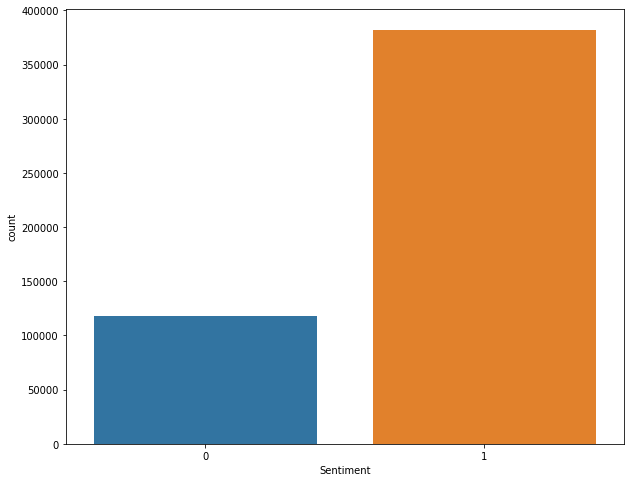

In [23]:
##Distribution of sentiment
plt.figure(figsize = ( 10,8))
sns.countplot(data = df_1, x = 'Sentiment')
plt.show()

In [24]:
import re
def clean_text(Review):
   
    Review = str(Review).lower() # convert to lowercase
    Review = re.sub('\[.*?\]', '', Review) 
    Review = re.sub('https?://\S+|www\.\S+', '', Review) # Remove URls
    Review = re.sub('<.*?>+', '', Review)
    Review = re.sub(r'[^a-z0-9\s]', '', Review) # Remove punctuation
    Review = re.sub('\n', '', Review)
    Review = re.sub('\w*\d\w*', '', Review)
    return Review

In [25]:
df_1['Review'] = df_1['Review'].apply(clean_text)

In [26]:
df_1

,Review,Sentiment
0,if your into space this is the calendar for you,1
1,awesome pictures,1
2,great wall art and information for space explo...,1
3,as always it is a quality calendar full of ver...,1
4,this is a fantastic calendar this is my third ...,1
...,...,...
499995,i got this in the mail the other day its supe...,0
499996,its adorable not he best quality but for who...,1
499997,i got it for my besties d even though the back...,1
499998,i love this iphone case soooo much super cute ...,1


In [27]:
##Importing modules for model training
import nltk
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer ,ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [28]:
Y = df_1['Sentiment']

In [29]:
#make word vector and remove stop words
vect = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS, ngram_range=(1, 2), max_features=200, token_pattern=r'\b[^\d\W][^\d\W]+\b').fit(df_1.Review)
X = vect.transform(df_1.Review)
print(X)

  (2, 121)	0.8683120478056734
  (2, 74)	0.4960183339711527
  (3, 198)	0.5545665857111514
  (3, 142)	0.4072436349134639
  (3, 114)	0.43101351666770676
  (3, 103)	0.4173923991770014
  (3, 20)	0.40819046705447304
  (4, 198)	1.0
  (5, 198)	0.8831719476183381
  (5, 74)	0.46904936940585634
  (6, 198)	0.5700255802688496
  (6, 107)	0.5757266122082049
  (6, 100)	0.5019552913049773
  (6, 74)	0.3027384867593813
  (7, 198)	1.0
  (8, 107)	0.8850927334903523
  (8, 74)	0.46541471090047865
  (10, 103)	0.6634637130623914
  (10, 9)	0.7482084612255229
  (11, 11)	1.0
  (12, 102)	1.0
  (13, 115)	1.0
  (14, 115)	0.7726653923051
  (14, 114)	0.3799823887484464
  (14, 16)	0.50852883475279
  :	:
  (499897, 143)	0.48016101802175937
  (499897, 142)	0.345616516087911
  (499897, 83)	0.35693365331714133
  (499897, 75)	0.421954147102572
  (499897, 9)	0.39947550954127165
  (499898, 84)	0.5288667390378884
  (499898, 76)	0.639315306240914
  (499898, 73)	0.5581898525999164
  (499899, 161)	0.28009871342620246
  (499899, 1

In [30]:
reviews_transformed = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())
print('Top 5 rows of the DataFrame: \n', reviews_transformed.head())

Top 5 rows of the DataFrame: 
    able  actually  amazon  arrived  ...  works great  worth      year  years
0   0.0       0.0     0.0      0.0  ...          0.0    0.0  0.000000    0.0
1   0.0       0.0     0.0      0.0  ...          0.0    0.0  0.000000    0.0
2   0.0       0.0     0.0      0.0  ...          0.0    0.0  0.000000    0.0
3   0.0       0.0     0.0      0.0  ...          0.0    0.0  0.554567    0.0
4   0.0       0.0     0.0      0.0  ...          0.0    0.0  1.000000    0.0

[5 rows x 200 columns]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [31]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(reviews_transformed, Y, test_size=0.2, random_state=456)

In [32]:
#train logistic Regression
log_reg = LogisticRegression().fit(X_train, y_train)

In [33]:
#Predict values and Accuracy
y_pred_lr = log_reg.predict(X_test)
score=accuracy_score(y_test,y_pred_lr)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 83.31%


In [34]:
##Precision ,Recall and F1 report for logistic regression
from sklearn.metrics import classification_report,confusion_matrix 
print(classification_report(y_test, y_pred_lr, target_names = ['Bad Reviews','Good Reviews']))

              precision    recall  f1-score   support

 Bad Reviews       0.71      0.50      0.58     23478
Good Reviews       0.86      0.94      0.90     76503

    accuracy                           0.83     99981
   macro avg       0.78      0.72      0.74     99981
weighted avg       0.82      0.83      0.82     99981



Text(0.5, 1.0, 'Confusion matrix for Logistic Regression')

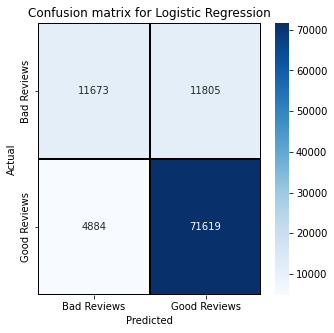

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Bad Reviews','Good Reviews'], 
            yticklabels = ['Bad Reviews','Good Reviews'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix for Logistic Regression")

In [36]:
###################################

In [37]:
# Rigde with TF-IDF
from sklearn import linear_model
import sklearn
import numpy as np
alpha_ridge = [500.0, 1500.0, 2500.0, 3000.0]
for a in alpha_ridge:
    ridge = linear_model.RidgeClassifier(a)
    scores_ridge = sklearn.model_selection.cross_val_score(ridge, X_train, y_train, cv=5, scoring='f1')
    print("alpha: ",a)
    print(scores_ridge)
    print(np.mean(scores_ridge))
    print('\n')

alpha:  500.0
[0.89048506 0.89089236 0.8904563  0.890404   0.8899997 ]
0.8904474836814134


alpha:  1500.0
[0.88230751 0.88243563 0.88265332 0.88177476 0.88251406]
0.8823370573692199


alpha:  2500.0
[0.87546953 0.87602973 0.8761457  0.87533648 0.87552693]
0.8757016736403942


alpha:  3000.0
[0.87286614 0.87317276 0.87342768 0.87305798 0.87309194]
0.8731233007559037




In [38]:
from sklearn.metrics import accuracy_score
ridge = linear_model.RidgeClassifier(1.4)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

accuracy_score(y_test, y_pred_ridge)

0.8262669907282384

In [39]:
##Precision ,Recall and F1 report for Ridge Classifier
from sklearn.metrics import classification_report,confusion_matrix 
print(classification_report(y_test, y_pred_ridge, target_names = ['Bad Reviews','Good Reviews']))

              precision    recall  f1-score   support

 Bad Reviews       0.74      0.40      0.52     23478
Good Reviews       0.84      0.96      0.89     76503

    accuracy                           0.83     99981
   macro avg       0.79      0.68      0.71     99981
weighted avg       0.82      0.83      0.81     99981



Text(0.5, 1.0, 'Confusion matrix for Ridge Classifier')

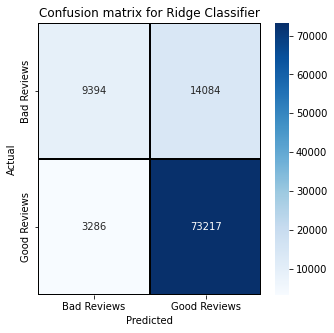

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred_ridge)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Bad Reviews','Good Reviews'], 
            yticklabels = ['Bad Reviews','Good Reviews'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix for Ridge Classifier")

In [41]:
# MultinomialNB with TF-IDF
from sklearn.naive_bayes import MultinomialNB

alpha_nb = [175.0, 200.0, 225.0, 250.0, 300.0]
for a in alpha_nb:
    mnb = MultinomialNB()
    scores_nb = sklearn.model_selection.cross_val_score(mnb, X_train, y_train, cv=5, scoring='f1')
    print('alpha: ', a)
    print(scores_nb)
    print(np.mean(scores_nb))
    print('\n')

alpha:  175.0
[0.87897389 0.87873071 0.87901902 0.87852426 0.87842389]
0.8787343539984734


alpha:  200.0
[0.87897389 0.87873071 0.87901902 0.87852426 0.87842389]
0.8787343539984734


alpha:  225.0
[0.87897389 0.87873071 0.87901902 0.87852426 0.87842389]
0.8787343539984734


alpha:  250.0
[0.87897389 0.87873071 0.87901902 0.87852426 0.87842389]
0.8787343539984734


alpha:  300.0
[0.87897389 0.87873071 0.87901902 0.87852426 0.87842389]
0.8787343539984734




In [42]:
from sklearn.metrics import accuracy_score

mnb.fit(X_train, y_train)
y_pred_nb = mnb.predict(X_test)

accuracy_score(y_test, y_pred_nb)

0.7912803432652203

In [43]:
##Precision ,Recall and F1 report for logistic regression
from sklearn.metrics import classification_report,confusion_matrix 
print(classification_report(y_test, y_pred_nb, target_names = ['Bad Reviews','Good Reviews']))

              precision    recall  f1-score   support

 Bad Reviews       0.87      0.13      0.23     23478
Good Reviews       0.79      0.99      0.88     76503

    accuracy                           0.79     99981
   macro avg       0.83      0.56      0.55     99981
weighted avg       0.81      0.79      0.73     99981



Text(0.5, 1.0, 'Confusion matrix for Multinomial Naive Bayes')

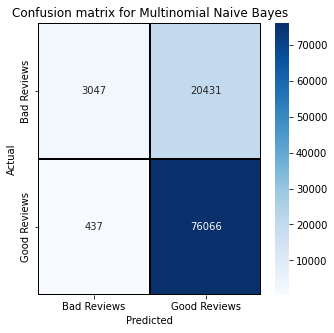

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Bad Reviews','Good Reviews'], 
            yticklabels = ['Bad Reviews','Good Reviews'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix for Multinomial Naive Bayes")

In [ ]:
#######################################3

In [ ]:
##Saving the model

In [49]:
import pickle
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(log_reg, open(filename, 'wb'))

In [54]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test,y_test)
print(result)

0.833078284874126
